In [27]:
import pandas as pd 
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [9]:
sao_goncalo_data = pd.read_csv("data/data.csv")

sao_goncalo_data = sao_goncalo_data[sao_goncalo_data['Rio'] != 'lagoa dos patos']

sao_goncalo_data['ds'] = pd.to_datetime(sao_goncalo_data['ds'])

sao_goncalo_data['ds'] = sao_goncalo_data['ds'].dt.strftime('%d-%m-%Y, %H:%M:%S')

In [10]:
sao_goncalo_data.head()

,ds,Rio,y
1,"05-04-2024, 14:00:00",sao goncalo,1.94
3,"05-04-2024, 20:00:00",sao goncalo,1.88
5,"05-05-2024, 15:00:00",sao goncalo,2.02
7,"05-05-2024, 20:00:00",sao goncalo,2.03
9,"05-06-2024, 09:00:00",sao goncalo,2.08


In [12]:
pos_vento = pd.read_csv("data/vento.csv")

pos_vento['ds'] = pd.to_datetime(pos_vento['ds'])

pos_vento['ds'] = pos_vento['ds'].dt.strftime('%d-%m-%Y, %H:%M:%S')

sao_goncalo_data = pd.merge(sao_goncalo_data, pos_vento, on="ds")

14:25:51 - cmdstanpy - INFO - Chain [1] start processing
14:25:51 - cmdstanpy - INFO - Chain [1] done processing


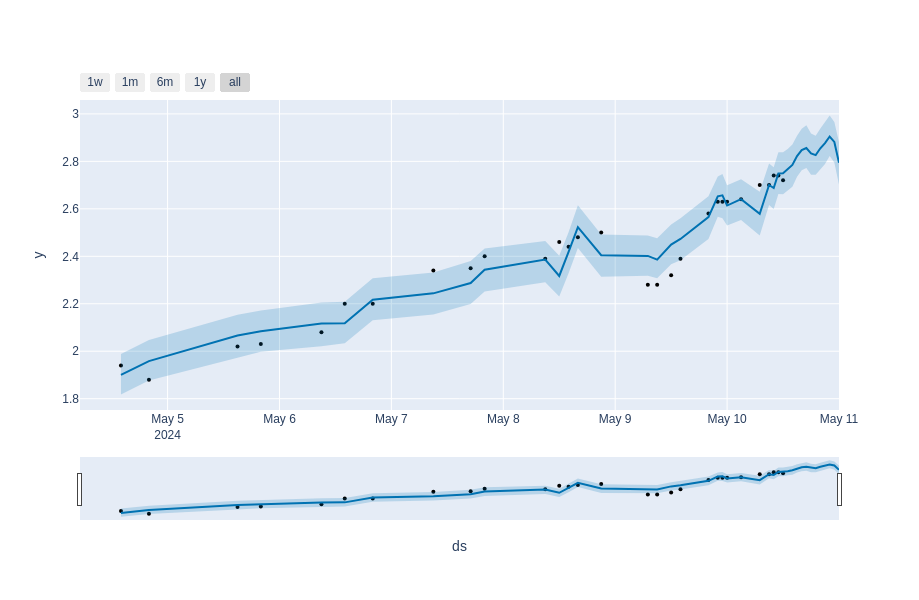

In [13]:
m = Prophet(
    yearly_seasonality=False,  
    weekly_seasonality=False,  
    daily_seasonality=True,    
    changepoint_range=0.8,     
    changepoint_prior_scale=0.7,
    changepoints=['2024-05-09 04:00:00'],
    growth="linear"         
)

# Defina os pontos de mudança
m.add_seasonality(name='daily', period=1, fourier_order=1, prior_scale = 0.01)
m.add_regressor("pos_vento", mode = "multiplicative", prior_scale = 0.8)

# Ajuste o modelo
m.fit(sao_goncalo_data)

# Realize previsões
future = m.make_future_dataframe(periods=12, freq='h')  

future['pos_vento'] = pos_vento['pos_vento']

forecast = m.predict(future)

# Visualize o resultado do modelo
plot_plotly(m, forecast)

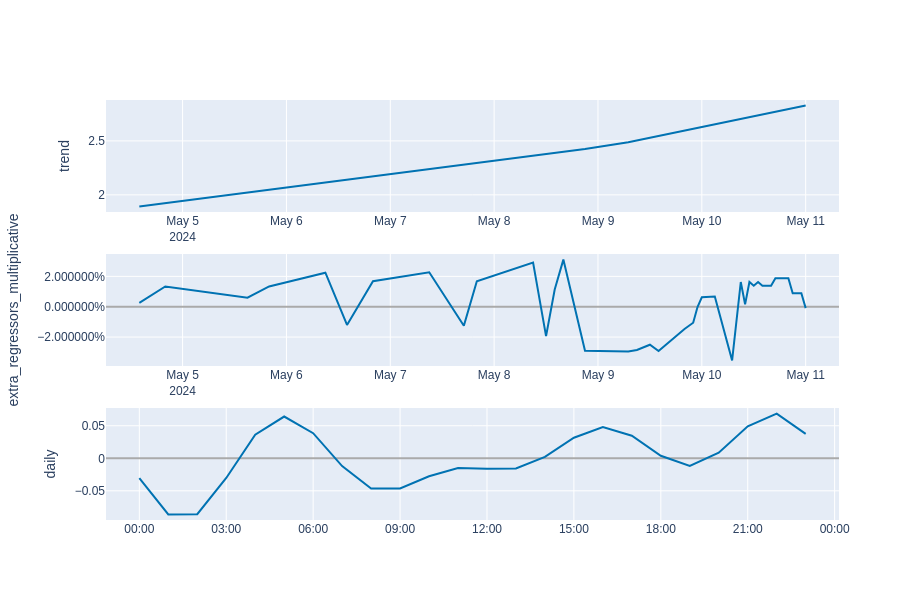

In [16]:
plot_components_plotly(m, forecast)

In [24]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='2 days', period='12 days', horizon = '3 days')
df_cv.head()

  0%|          | 0/1 [00:00<?, ?it/s]

14:38:06 - cmdstanpy - INFO - Chain [1] start processing
14:38:06 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2024-05-07 17:00:00,-1.087496,-1.095401,-1.080222,2.35,2024-05-07 12:00:00
1,2024-05-07 20:00:00,2.399244,2.391883,2.406509,2.40,2024-05-07 12:00:00
2,2024-05-08 09:00:00,2.650557,2.643281,2.658388,2.39,2024-05-07 12:00:00
3,2024-05-08 12:00:00,-1.329461,-1.336832,-1.321425,2.46,2024-05-07 12:00:00
4,2024-05-08 14:00:00,2.324368,2.316794,2.331546,2.44,2024-05-07 12:00:00


In [25]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,0 days 08:00:00,5.908188,2.430676,1.719126,0.731540,0.731540,1.000158,0.5
1,0 days 21:00:00,0.033945,0.184242,0.130656,0.054667,0.054667,0.051850,0.5
2,1 days 00:00:00,7.213954,2.685880,2.025009,0.824725,0.824725,1.051692,0.0
3,1 days 02:00:00,7.186694,2.680801,1.952546,0.793911,0.793911,1.024270,0.0
4,1 days 04:00:00,1.108199,1.052710,0.799946,0.322941,0.322941,0.451304,0.0


/home/dell/anaconda3/envs/flood-rs/lib/python3.12/site-packages/prophet/plot.py:546: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.

/home/dell/anaconda3/envs/flood-rs/lib/python3.12/site-packages/prophet/plot.py:547: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



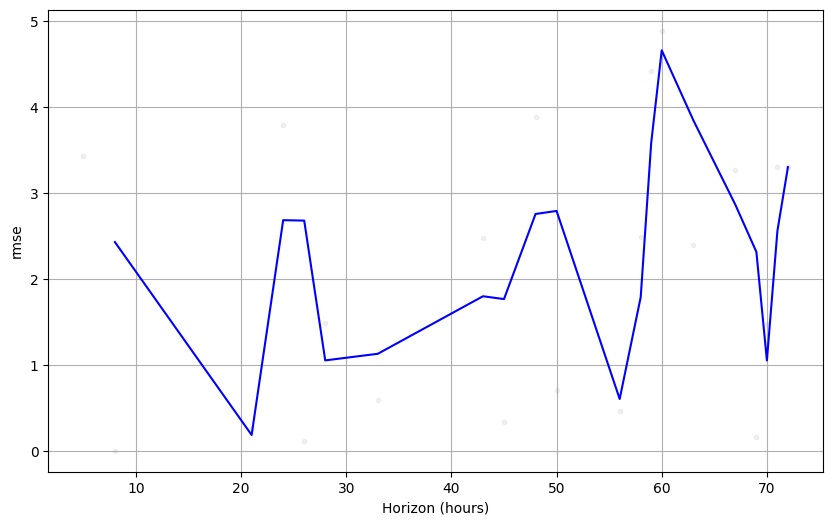

In [29]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')